In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost
from xgboost import XGBClassifier

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
data_path = '/home/mvkrein/etf_model/data'
etf_data_file = os.path.join(data_path,'etf_new_var_20180910.csv')
etf_data = pd.read_csv(etf_data_file,index_col=0)

In [5]:
etf_study_file = os.path.join(data_path,'ETF_list_min_6yr_history.csv')
etf_list = pd.read_csv(etf_study_file,index_col=0)
etf_data.sort_values(['Date','sym'],ascending=True,inplace=True)
etf_data.reset_index(drop=True,inplace=True)

In [6]:
drop_columns = ['Date','sym','p', 'v', 'p_L05', 'v_L05', 'p_L10', 'v_L10', 'p_L21', 'v_L21', 'p_L42', 'v_L42', 'p_L63', \
                'v_L63', 'p_L84', 'v_L84', 'p_L126', 'v_L126', 'p_L189', 'v_L189', 'p_L252', 'v_L252',\
                'p_L-21', 'v_L-21', 'delta_p_L05', 'delta_p_L10', 'delta_p_L21', 'delta_p_L42', 'delta_p_L63', \
                'delta_p_L84', 'delta_p_L126', 'delta_p_L189', 'delta_p_L252', 'delta_p_L-21', 'delta_v_L05',\
                'delta_v_L10', 'delta_v_L21', 'delta_v_L42', 'delta_v_L63', 'delta_v_L84', 'delta_v_L126', \
                'delta_v_L189', 'delta_v_L252','rank_p_L-21', 'ivv_delta_p_L-21', 'target']

rank_col = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
            'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']

In [7]:
all_columns = list(etf_data.columns)

In [8]:
include_columns = [x for x in all_columns if x not in drop_columns]
# include_columns = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
#             'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']
# include_columns = ['rank_p_L05','rank_p_L21','rank_p_L42','rank_p_L252']

In [9]:
str(1 % 21)

'1'

In [10]:
len(include_columns)

360

In [11]:
dates = list(etf_data['Date'].unique())
# dates[1671]

In [12]:
symbols = etf_list['Symbol'].unique()

In [13]:
len(symbols)

153

In [14]:
#Each year has 252 trading dates.  Need two years to fully develop variables.
dt1 = 504 #This is the first day that all variables are developed
# dt1 = 504 + 21 + 273 #This is the first day that all variables are developed 2016-04-07
# make all dates relative to dt1
# for one year training - add 252
# to evaluate for one month outside the training window - add 273
# to predict for the first day outside of the evaluation window (have to lag 21) - add 294
dt_end = (len(dates) - 273 - 21) - 1
# dt_end = dt1 + 1
etf_predict_file = os.path.join(data_path,'etf_linear_ridge_20180928.csv')

In [20]:

for i in range(dt1,dt_end,21):
    print("Building model to predict for ",dates[i+273])
    x_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns] #train with 12 mos
    y_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['rank_p_L-21']] #train with 12 mos

    x_test = etf_data.loc[(etf_data['Date']==dates[i+273]),include_columns]#predict one day-must be 21 days removed from training
    y_test = etf_data.loc[(etf_data['Date']==dates[i+273]),['rank_p_L-21']] #predict if etf >= market
    returns = etf_data.loc[(etf_data['Date']==dates[i+273]),['delta_p_L-21']]
    mkt_return = etf_data.loc[(etf_data['Date']==dates[i+273]),['ivv_delta_p_L-21']]
    x_train_nmpy = x_train.as_matrix()
    y_train_nmpy = np.ravel(y_train.as_matrix())

    x_test_nmpy = x_test.as_matrix()
    y_test_nmpy = np.ravel(y_test.as_matrix())
    returns_nmpy = returns.as_matrix()
    mkt_return_nmpy = mkt_return.as_matrix()

    lm = linear_model.Ridge (alpha = 0.8)
#     lm = LinearRegression()

    lm.fit(x_train_nmpy, y_train_nmpy)
    
    y_train_model = lm.predict(x_train_nmpy)
    y_pred_model = lm.predict(x_test_nmpy)


    y_check = np.column_stack((y_test_nmpy, y_pred_model,mkt_return_nmpy,returns_nmpy))
    y_check_df = pd.DataFrame(y_check,columns=['true_value','pred_value','mkt_return','returns'])
    y_check_df.sort_values('pred_value',inplace=True,ascending=False)
    

    train_error = mean_squared_error(y_train_nmpy,lm.predict(x_train_nmpy))
    eval_error = mean_squared_error(y_test_nmpy,y_pred_model)

    print('Model Eval Results:')
    print('*****************************')

    print(f'training error: {train_error:.3}')
    print(f'evaluation error: {eval_error:.3}')
    print('R-squared score (training): {:.3f}'
     .format(r2_score(y_train_nmpy,y_train_model)))
    print('R-squared score (test): {:.3f}'
     .format(r2_score(y_test_nmpy, y_pred_model)))

    print('*****************************')
    print("Model Top 5 Picks")
    print(" Avg rtn top 5:", round(y_check_df['returns'][0:5].mean(),4))
    print(y_check_df.head(5))
    print("Model Bottom 5 Picks")
    print(" Avg rtn bottom 5:", round(y_check_df['returns'][-5:].mean(),4))
    print(y_check_df.tail(5))
    print('********************************************************')
    if i == dt1:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file)
    else:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file,header=False,mode='a')

Building model to predict for  2015-02-05
Model Eval Results:
*****************************
training error: 0.0704
evaluation error: 0.0619
R-squared score (training): 0.154
R-squared score (test): 0.257
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0389
     true_value  pred_value  mkt_return   returns
139    0.960784    0.767997    0.010741  0.060291
67     0.882353    0.759569    0.010741  0.031835
45     0.888889    0.687149    0.010741  0.036401
70     0.986928    0.681460    0.010741  0.071770
150    0.437908    0.675154    0.010741 -0.005800
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0282
    true_value  pred_value  mkt_return   returns
39    0.287582    0.309723    0.010741 -0.016544
15    0.764706    0.308307    0.010741  0.012313
23    0.326797    0.302292    0.010741 -0.013518
69    0.045752    0.301091    0.010741 -0.081433
78    0.137255    0.288340    0.010741 -0.041616
********************************************************
Building model to predict 

Model Eval Results:
*****************************
training error: 0.0605
evaluation error: 0.0908
R-squared score (training): 0.273
R-squared score (test): -0.090
*****************************
Model Top 5 Picks
 Avg rtn top 5: -0.0303
     true_value  pred_value  mkt_return   returns
143    0.091503    0.858060   -0.003687 -0.057326
50     0.084967    0.812744   -0.003687 -0.057692
89     0.444444    0.689992   -0.003687 -0.006480
26     0.398693    0.672481   -0.003687 -0.008807
132    0.235294    0.671416   -0.003687 -0.020979
Model Bottom 5 Picks
 Avg rtn bottom 5: -0.0379
     true_value  pred_value  mkt_return   returns
51     0.169935    0.254008   -0.003687 -0.036261
78     0.065359    0.252975   -0.003687 -0.073245
60     0.137255    0.177085   -0.003687 -0.044990
126    0.189542    0.168075   -0.003687 -0.033092
15     0.653595    0.145281   -0.003687 -0.001742
********************************************************
Building model to predict for  2015-12-04
Model Eval Results

Model Eval Results:
*****************************
training error: 0.0639
evaluation error: 0.0873
R-squared score (training): 0.233
R-squared score (test): -0.048
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0398
    true_value  pred_value  mkt_return   returns
76    0.895425    0.825774    0.004421  0.051487
24    0.967320    0.774607    0.004421  0.071390
46    0.980392    0.774162    0.004421  0.084112
79    0.686275    0.770470    0.004421  0.025326
89    0.019608    0.764737    0.004421 -0.033391
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0217
    true_value  pred_value  mkt_return   returns
75    0.901961    0.295771    0.004421  0.051905
23    0.032680    0.293607    0.004421 -0.014706
52    0.745098    0.290576    0.004421  0.032764
18    0.653595    0.265905    0.004421  0.021873
50    0.562092    0.227823    0.004421  0.016861
********************************************************
Building model to predict for  2016-09-06
Model Eval Results:
************

Model Eval Results:
*****************************
training error: 0.0693
evaluation error: 0.0952
R-squared score (training): 0.168
R-squared score (test): -0.142
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0157
     true_value  pred_value  mkt_return   returns
40     0.307190    0.792034    0.016918  0.010826
52     0.928105    0.768947    0.016918  0.047050
33     0.209150    0.669450    0.016918  0.004556
62     0.065359    0.668473    0.016918 -0.012830
118    0.732026    0.663024    0.016918  0.028816
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.0049
     true_value  pred_value  mkt_return   returns
81     0.039216    0.290661    0.016918 -0.040798
138    0.986928    0.285525    0.016918  0.080467
103    0.411765    0.284236    0.016918  0.014653
75     0.013072    0.248996    0.016918 -0.074023
79     0.901961    0.231756    0.016918  0.044360
********************************************************
Building model to predict for  2017-06-07
Model Eval Results:


Model Eval Results:
*****************************
training error: 0.0691
evaluation error: 0.081
R-squared score (training): 0.170
R-squared score (test): -0.011
*****************************
Model Top 5 Picks
 Avg rtn top 5: 0.0047
     true_value  pred_value  mkt_return   returns
126    0.196078    0.720020    0.017953 -0.010701
104    0.058824    0.682951    0.017953 -0.037759
46     0.352941    0.675681    0.017953 -0.002727
57     0.960784    0.673415    0.017953  0.066020
39     0.627451    0.661502    0.017953  0.008631
Model Bottom 5 Picks
 Avg rtn bottom 5: 0.008
     true_value  pred_value  mkt_return   returns
136    0.470588    0.267431    0.017953  0.000944
74     0.424837    0.265940    0.017953 -0.001136
137    0.431373    0.258168    0.017953 -0.000884
141    0.503268    0.254732    0.017953  0.001814
68     0.901961    0.231979    0.017953  0.039387
********************************************************
Building model to predict for  2018-03-08
Model Eval Results:
**

In [21]:
lm.intercept_

0.11638660086020819

In [22]:
model_coef = pd.DataFrame({'Feature':include_columns,'Coefficient': lm.coef_})
model_coef.sort_values(by='Coefficient',inplace=True,ascending=False) 
model_coef.reset_index(drop=True,inplace=True)
model_coef

,Coefficient,Feature
0,0.854918,w252_rank_p_L189_avg
1,0.854918,w252_rank_v_L189_avg
2,0.700064,w189_rank_p_L252_avg
3,0.700064,w189_rank_v_L252_avg
4,0.576567,w126_rank_v_L42_avg
5,0.576567,w126_rank_p_L42_avg
6,0.558991,w189_rank_p_L21_avg
7,0.558991,w189_rank_v_L21_avg
8,0.529128,w189_rank_p_L05_avg
9,0.529128,w189_rank_v_L05_avg


<IPython.core.display.Javascript object>


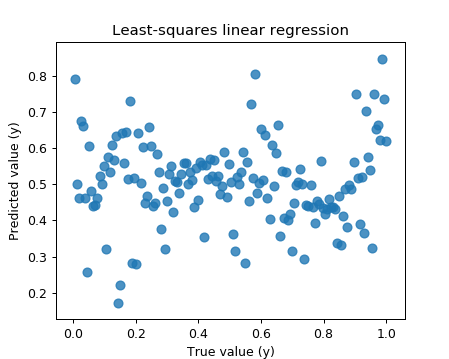

In [23]:
plt.figure(figsize=(5,4))
plt.scatter(y_test_nmpy, y_pred_model,marker= 'o', s=50, alpha=0.8)
#plt.plot(y_test_nmpy, y_pred_model, 'r-')
plt.title('Least-squares linear regression')
plt.xlabel('True value (y)')
plt.ylabel('Predicted value (y)')
plt.show()